# Read ME



Las datos de [entranamiento](https://drive.google.com/file/d/1tfo6qm8zB5Eb7TY8WQGey-SqwBiC-3uO/view?usp=sharing) y [prueba](https://drive.google.com/file/d/1--yMo6lHVrkU9iqXUjLIJpKLYaz7QfLF/view?usp=sharing) fueron descargados de la plataforma [zoo galaxy](https://data.galaxyzoo.org/#section-21) correspondientes al Galaxy Zoo 2 ([images_gz2.zip](https://zenodo.org/records/3565489#.Y3vFKS-l0eY)).
Dichos datos estan almacenados en formato "[.pkl](https://drive.google.com/drive/folders/1XalRlt11sYmU11op2z3xPnVsRt8Pz0VM?usp=drive_link)" en lugar del formato original de ".jpg" para faciliar el manejor de los mismos. Se trata de la información de 10,000 imagens de entrenamiento y 5,000 de prueba. La información se encuentra reducida a 75 pixles por imagenes siendo de 5x5 pixeles en tress canales de color. Para poder observar la galaxia es precsiso recosntruir la imagen

# Set up

## Packages

In [ ]:
# Mount Google Drive to access and store files
# Comment out this cell if running the script locally

from google.colab import drive
drive.mount('/content/drive', force_remount=True)  # Force remount to ensure access


Mounted at /content/drive


In [ ]:
import os
import io

import time

import math
import h5py
import random

import requests

import numpy as np
import matplotlib.pyplot as plt

# Machine learning tools for feature reduction and data scaling
from sklearn.decomposition import IncrementalPCA  # Performs incremental PCA for large datasets
from sklearn.preprocessing import StandardScaler  # Standardizes data before applying PCA
import joblib                                     # For saving and loading machine learning models


In [ ]:
# Import clustering algorithms and evaluation metrics from scikit-learn

from sklearn.cluster import KMeans           # Standard K-Means clustering algorithm
from sklearn import metrics                  # Tools for evaluating clustering performance
from sklearn.cluster import MiniBatchKMeans  # Mini-batch version of K-Means for large datasets


## Funtions

In [40]:
def load_data(data='train'):
    """
    Downloads and loads preprocessed training or testing data from Google Drive.

    Parameters:
    - data (str): Specifies which dataset to load ('train' or 'test').

    Returns:
    - DATA (numpy array or None): The loaded dataset if successful, otherwise None.
    """

    # Define Google Drive file IDs for train and test datasets
    if data.lower() == 'train':
        file_id = '1-8JHObeY7kaU0qLt0p7WDFRJf6A6iYFN'  # File ID for training data

    elif data.lower() == 'test':
        file_id = '1bdjlyKp02O04uGkixX1E4mQMkUjvWRbL'  # File ID for test data

    else:
        print('Error: Type of data invalid')  # Handle incorrect input
        return None

    # Construct the download URL
    url = f"https://drive.google.com/uc?export=download&id={file_id}"

    # Request file from Google Drive
    respuesta = requests.get(url)

    # Load the file as a byte stream
    file_stream = io.BytesIO(respuesta.content)

    # Load the dataset using joblib
    DATA = joblib.load(file_stream)

    # Confirm successful data loading
    print(f'{data.lower()} data loaded\nShape: {DATA.shape}')

    return DATA




def single_reconverter(data):
    """
    Takes a single PCA-transformed data point, reverses the PCA and scaling transformations,
    and normalizes it before reshaping it into an image.

    Parameters:
    - data (numpy array): A single data point in PCA-reduced form.

    Returns:
    - norm_centroides (numpy array): Reconstructed image (174x174x3).
    """
    data = data.reshape(1, -1)  # Ensure data is a 2D array
    centroides = scaler.inverse_transform(data)  # Reverse standard scaling
    centroides = ipca.inverse_transform(centroides)  # Reverse PCA transformation
    norm_centroides = normalized(centroides)  # Normalize pixel values
    norm_centroides = norm_centroides.reshape(174, 174, 3)  # Reshape into an image
    return norm_centroides


def reconverter(data):
    """
    Reconstructs multiple PCA-reduced data points back into images.

    Parameters:
    - data (numpy array): Multiple PCA-transformed data points.

    Returns:
    - norm_centroides (numpy array): Reconstructed images with normalized pixel values.
    """
    centroides = scaler.inverse_transform(data)  # Reverse scaling
    centroides = ipca.inverse_transform(centroides)  # Reverse PCA
    norm_centroides = normalized(centroides)  # Normalize pixel values
    return norm_centroides


def normalized(data):
    """
    Normalizes data to the range [0,1] using min-max scaling.

    Parameters:
    - data (numpy array): Input data.

    Returns:
    - norm (numpy array): Normalized data.
    """
    norm = (data - data.min()) / (data.max() - data.min())  # Min-max normalization
    return norm


def grafica_centroides(data):
    """
    Displays the reconstructed centroids as images.

    Parameters:
    - data (numpy array): Array of reconstructed centroid images.

    Returns:
    - None
    """
    filas = math.ceil(clusters / 5)  # Determine number of rows dynamically
    columnas = 5  # Fixed number of columns for visualization

    #plt.figure(figsize=(2 * columnas, 2.5 * filas))  # Set figure size
    plt.figure(figsize=(12, 12))  # Set figure size

    for i in range(clusters):  # Loop through each cluster's centroid
        img = data[i].reshape(174, 174, 3)  # Reshape into image format

        plt.subplot(columnas, filas, i + 1)  # Define subplot
        plt.title(f'Clase: {i}')  # Title for each centroid
        plt.imshow(img)  # Display the image
        plt.axis('off')  # Remove axis for better visualization

    # Set a global title and adjust layout
    plt.suptitle('Centroides de cada clase')
    plt.subplots_adjust(top=0.9, wspace=0.05, hspace=0.5)
    plt.tight_layout()
    plt.savefig(f'{root_result}Centroides_K-mean.pdf')
    plt.show()
    return None


def histogram(labels, num_clusters, name):
    """
    Plots a histogram of cluster distribution with a semi-logarithmic scale.

    Parameters:
    - labels (array-like): Cluster assignments for each sample.
    - bins (int or sequence): Number of bins or bin edges for the histogram.
    - name (str): File name for saving the plot.

    Returns:
    - None
    """

    # Define bin edges for the histogram, covering all cluster indices
    bins = np.arange(0, num_clusters + 1)

    # Set up the figure size for better visualization
    plt.figure(figsize=(15, 4))

    # Set the title of the plot
    plt.title('Distribution for Each Cluster')

    # Use a semi-logarithmic scale to highlight differences in frequency
    plt.semilogy()

    # Plot a histogram showing the frequency of samples in each cluster
    frecuencia, clases, _ = plt.hist(labels, bins=bins, rwidth=0.8)

    # Label the axes
    plt.xlabel('Cluster')
    plt.ylabel('Frequency')

    # Set cluster numbers as x-axis ticks (centered between bins)
    plt.xticks(bins[:-1] + 0.5, bins[:-1])

    # Add a grid along the y-axis for better readability
    plt.grid(axis='y')

    # Adjust layout to prevent overlapping elements
    plt.tight_layout()

    # Save the figure as a PDF file in the results directory
    plt.savefig(f'{root_result}{name}.pdf')

    # Display the plot
    plt.show()

    return None


## Directories

In [ ]:
### Drive roots ####

root_train ='/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/train_data.pkl'
root_test ='/content/drive/MyDrive/Practicas_Profesionales/Data/PKLs/test_data.pkl'

root_ipca = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl'
root_scaler = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl'

root_kmean = '/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/K-mean.pkl'
root_result = '/content/drive/MyDrive/Practicas_Profesionales/Results/k-mean/'

In [ ]:
# ### Local roots ####

# root_train ='/home/tonathiu/Fisica/Practicas_Profesionales/Data/train_data.pkl'
# root_test ='/home/tonathiu/Fisica/Practicas_Profesionales/Data/test_data.pkl'

# root_ipca = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/Pre-processing/reduce_dimensions.pkl'
# root_scaler = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/Pre-processing/scaler.pkl'

# root_kmean = '/home/tonathiu/Fisica/Practicas_Profesionales/Codes/Models/K-mean.pkl'
# root_result = '/home/tonathiu/Fisica/Practicas_Profesionales/Results/k-mean/'

## Load Models

In [ ]:
ipca = joblib.load(root_ipca)
scaler = joblib.load(root_scaler)

# [K-means](https://scikit-learn.org/stable/modules/generated/sklearn.cluster.KMeans.html)

## Load Train Data

In [ ]:
train_data = load_data('train')

train data loaded
Shape: (10000, 75)


In [ ]:
# train_data = joblib.load(root_train)
# Test_data = joblib.load(root_test)

## Train k mean

In [43]:
# Define the number of clusters for K-Means clustering
clusters = 20

# Train a MiniBatchKMeans model for clustering the PCA-transformed training data
Kmeans_model = MiniBatchKMeans(
    n_clusters=clusters,  # Number of clusters to identify
    batch_size=250,  # Number of samples processed per iteration (helps with large datasets)
    random_state=13,  # Ensures reproducibility of results
    max_iter=500,  # Maximum number of iterations for convergence
    init='k-means++'  # Smart initialization to improve convergence speed
).fit(train_data)  # Fit the model on the PCA-transformed training data


## Clasification

In [44]:
labels = Kmeans_model.predict(train_data)


## Centroides

In [45]:
# Extract the centroids from the trained K-Means model
centroides = Kmeans_model.cluster_centers_

# Convert the PCA-reduced centroids back to the original image space
centroides_normalizados = reconverter(centroides)


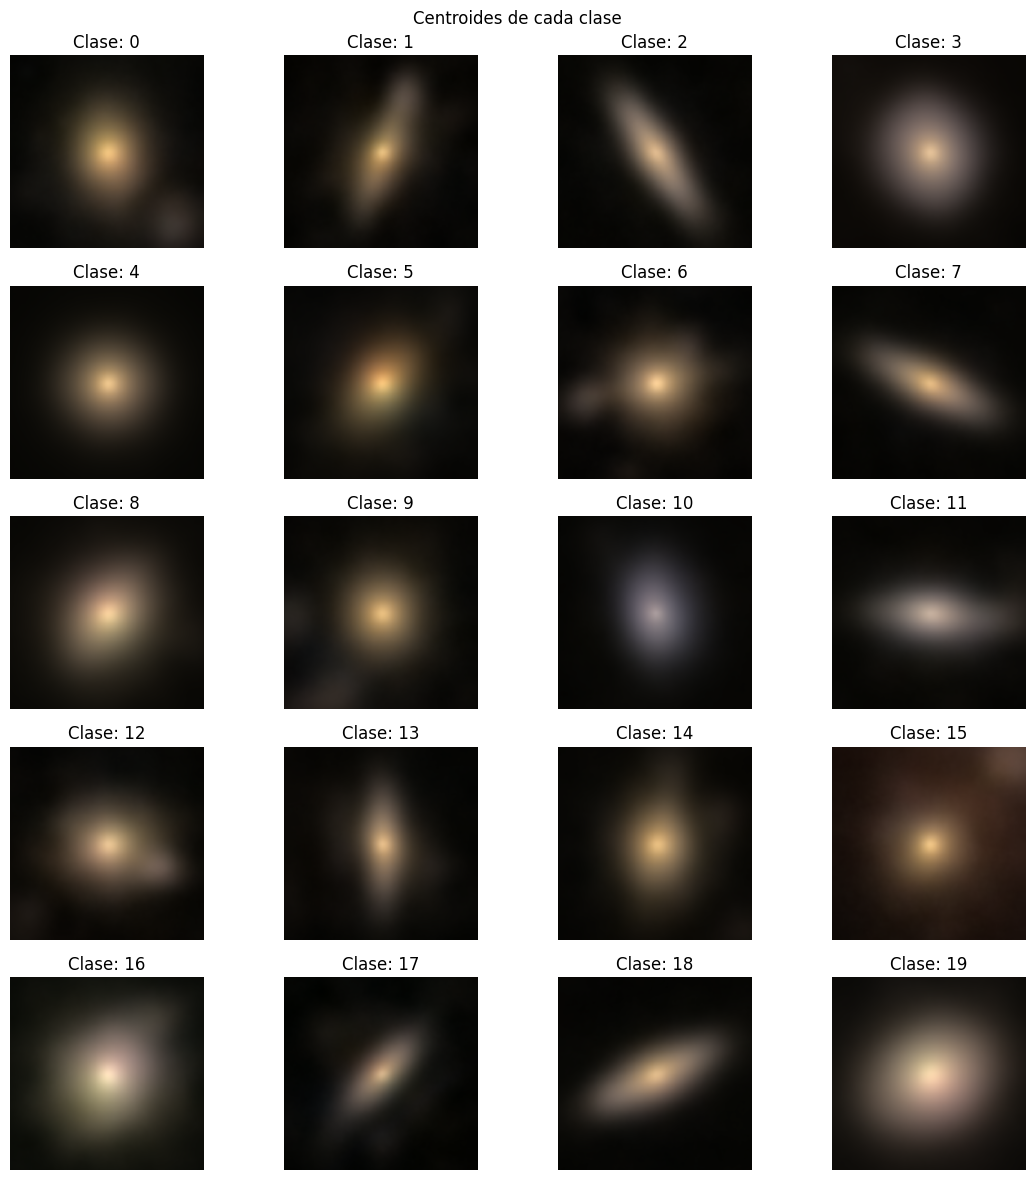

In [46]:
clusters=20
grafica_centroides(centroides_normalizados)

## Histogram

In [47]:
clusters

20

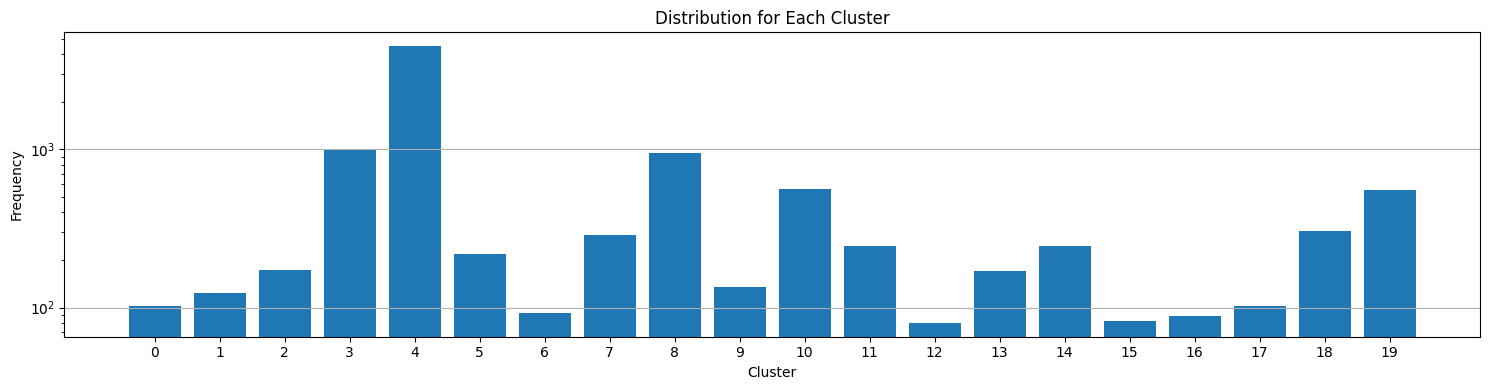

In [48]:
histogram(labels,clusters,'Train_data_histograma_K-mean')

## Save

In [ ]:
joblib.dump(Kmeans_model,root_kmean)

['/content/drive/MyDrive/Practicas_Profesionales/Codes/Models/K-mean.pkl']

# Test K-means

## Load Data

In [ ]:
Test_data = load_data('test')


test data loaded
Shape: (5000, 75)


## Load k-means-Model

In [ ]:
KMeans_model = joblib.load(root_kmean)

## Classification


In [ ]:
# Predict cluster labels for the test dataset using the trained K-Means model
labels = KMeans_model.predict(Test_data)

# Determine the number of unique clusters found in the test data
num_clusters = len(np.unique(labels))


## Histogram

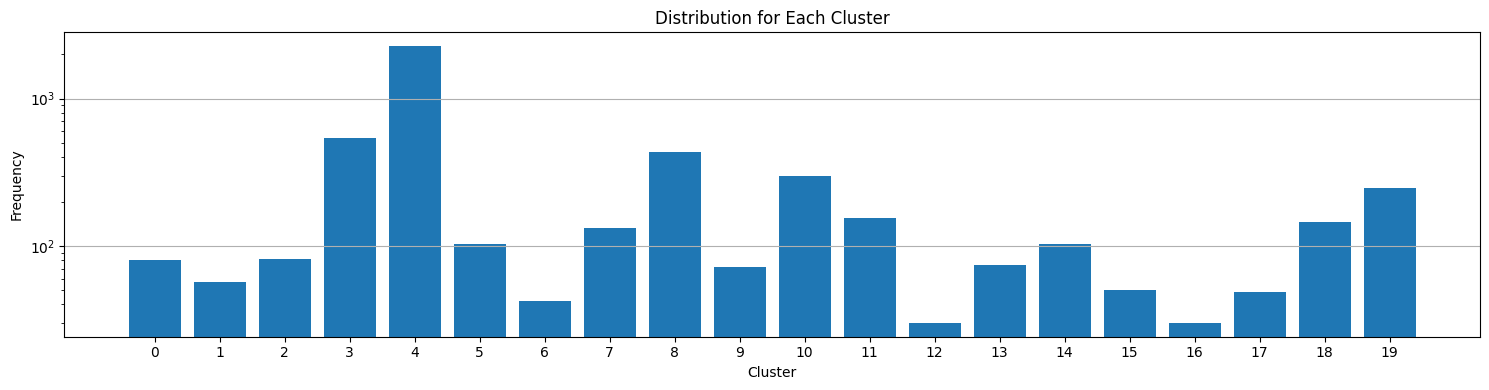

In [ ]:
histogram(labels,num_clusters,'Test_data_histograma_K-mean_')

In [ ]:
clusters=20

In [ ]:
# Get unique cluster labels from the test data predictions
etiquetas = np.unique(labels)

# Initialize plotting index
ploteo = 1

# Create a figure to display cluster samples
plt.figure(figsize=(10, 3 * clusters))

# Loop through each cluster label
for etq in etiquetas:
    cuenta = 0  # Counter for images per cluster

    # Iterate through all samples in the test data
    for i in range(len(labels)):
        rand = random.random()  # Generate a random number for sampling

        # Check if the sample belongs to the current cluster and add randomness to selection
        if etq == labels[i] and rand > 0.5:
            cuenta += 1  # Count images plotted for the cluster

            # Convert the PCA-transformed test sample back into an image
            img = single_reconverter(Test_data[i])

            # Plot the image in a subplot
            plt.subplot(clusters, 5, ploteo)
            plt.imshow(img)

            # Set a title for the first few images in the cluster
            if cuenta == 3:
                plt.title(f'Cluster {etq}')

            # Remove axes for better visualization
            plt.axis('off')

            # Increment the subplot index
            ploteo += 1

        # Limit to 5 images per cluster
        if cuenta == 5:
            break

# Adjust spacing between subplots
plt.subplots_adjust(wspace=0.01, hspace=0.5)
plt.savefig(f'{root_result}Clusters_K-mean.pdf')
# Display the figure
plt.show()


Output hidden; open in https://colab.research.google.com to view.